# Tensorflow: ANN with MNIST

MNIST is a dataset of handwritten digits from 0 to 9. It contains a training set of 60,000 examples and a test set of 10,000 examples. 

The idea of clustering is based on softmax. 

Softmax regression (or multinomial logistic regression) is a generalization of logistic regression to the case where we want to handle multiple classes. 

It has two steps: first we add up the evidence of our input being in certain classes, and then we convert that evidence into probabilities.

$$\text{softmax}(x)_i = \frac{\exp(x_i)}{\sum_j \exp(x_j)}$$

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import time
import timeit
import numpy as np

import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data

import matplotlib.pyplot as plt
#%matplotlib #inline

### Note: difference of timing functions

time.clock()

On Unix, return the current processor time as a floating point number expressed in seconds. The precision, and in fact the very definition of the meaning of “processor time”, depends on that of the C function of the same name, but in any case, \bf{this is the function to use for benchmarking Python or timing algorithms}.

However, time.clock() is deprecated after Python v3.3, and it's suggested to use time.process_time() or time.perf_counter() instead.

time.time()

time.time returns the time in seconds since the epoch.

Note:

The difference between time.time() and time.clock is nevertheless a long story. Long story short, time.clock() has a much higher precision than time.time() for Unix systems.

## 1.1 Time the single gradient evaluation

In [2]:
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)


Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [3]:

# Create the model
x = tf.placeholder(tf.float32, [None, 784])
W = tf.Variable(tf.zeros([784, 10]))
b = tf.Variable(tf.zeros([10]))
y = tf.matmul(x, W) + b


In [4]:
lsclock = []
lsgradval = []

# Note: larger batch size can result in longer gradient time
# Mnist has 60,000 files in the training dataset
bs = 100

# open a new session every time
with tf.Session() as sess:
    tf.set_random_seed(12345)
    #tf.initialize_all_variables().run()
    sess.run(tf.initialize_all_variables())
    
    y_ = tf.placeholder(tf.float32, [None, 10])
    # cost function
    cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(y, y_))
    # gradient virtual node
    var_grad = tf.gradients(cross_entropy, [W, b])[0]
    
    for i in range(10000):
        # get new batch
        batch_xs, batch_ys = mnist.train.next_batch(bs)
        # set start clock
        start_clock = time.clock()
        # this is the step to run gradient with actual batch
        var_grad_val = sess.run(var_grad, feed_dict={x: batch_xs, y_: batch_ys})
        lsclock.append(time.clock() - start_clock)
        lsgradval.append(var_grad_val)


In [5]:
# check the gradient values
np.sum(lsgradval, axis=1)

array([[-5.69122458,  4.4463048 ,  3.51944351, ...,  1.79387558,
        -2.58247709,  1.4623853 ],
       [-7.42252684,  4.14261341, -5.26173782, ...,  4.06723833,
         0.5260635 ,  1.53825891],
       [-7.76476908,  3.6500988 , -4.03821516, ...,  1.03339231,
        -3.18264627,  0.56241208],
       ..., 
       [ 4.12267637,  5.29216623, -3.14877748, ...,  5.20534134,
        -0.66755992, -3.37822962],
       [-6.6716733 ,  4.56691265, -3.42928219, ...,  3.70750165,
        -0.43594831, -1.73269272],
       [ 1.39868307,  0.40699643, -5.54175425, ..., -2.16214037,
        -5.43802214,  4.19448566]], dtype=float32)

### The first X iterations belong to a burn-in period. Here we exclude the first 50 iters.

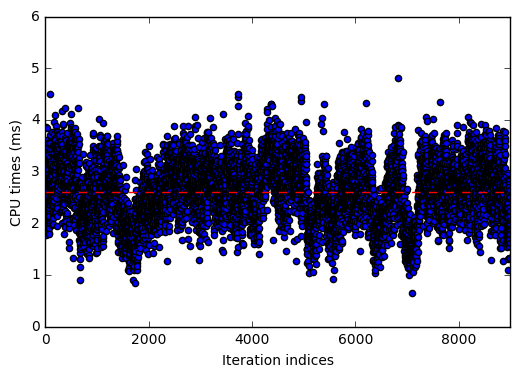

In [6]:

lsshow = map(lambda x: x * 1000, lsclock[1000:])

plt.scatter(range(len(lsshow)), lsshow)
plt.hlines(np.mean(lsshow), -2, len(lsshow)+2, colors='r', linestyles='dashed')
plt.xlim(-2, len(lsshow)+2)
plt.xlabel("Iteration indices")
plt.ylabel("CPU times (ms)")
plt.show()

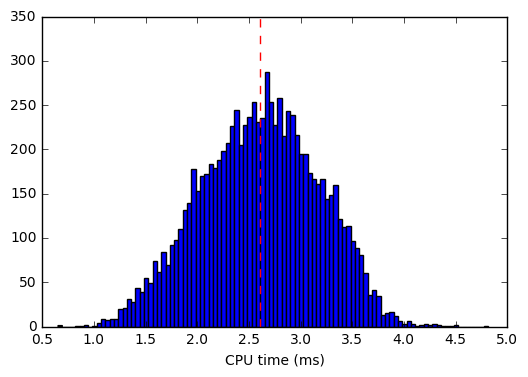

In [7]:
plt.hist(lsshow, bins=100)
plt.vlines(np.mean(lsshow), 0, 350, colors='r', linestyles='dashed')

plt.xlabel("CPU time (ms)")
plt.show()

## 1.2 Full model

"""A very simple MNIST classifier.
See extensive documentation at
http://tensorflow.org/tutorials/mnist/beginners/index.md
"""

In [8]:

# Create the model
x = tf.placeholder(tf.float32, [None, 784])
W = tf.Variable(tf.zeros([784, 10]))
b = tf.Variable(tf.zeros([10]))
y = tf.matmul(x, W) + b

# Define loss and optimizer
y_ = tf.placeholder(tf.float32, [None, 10])

# The raw formulation of cross-entropy,
#
#   tf.reduce_mean(-tf.reduce_sum(y_ * tf.log(tf.nn.softmax(y)),
#                                 reduction_indices=[1]))
#
# can be numerically unstable.
#
# So here we use tf.nn.softmax_cross_entropy_with_logits on the raw
# outputs of 'y', and then average across the batch.
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(y, y_))
train_step = tf.train.GradientDescentOptimizer(0.5).minimize(cross_entropy)

with tf.Session() as sess:
    # Train
    tf.initialize_all_variables().run()
    for _ in range(1000):
        batch_xs, batch_ys = mnist.train.next_batch(100)
        sess.run(train_step, feed_dict={x: batch_xs, y_: batch_ys})

    # Test trained model
    correct_prediction = tf.equal(tf.argmax(y, 1), tf.argmax(y_, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    compaccu = sess.run(accuracy, feed_dict={x: mnist.test.images, y_: mnist.test.labels})
    print('The prediction accuracy is: {}'.format(compaccu))


The prediction accuracy is: 0.916999995708
